# IIoT Network Analysis: Age of Information and Reliability Trade-offs

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense

In [3]:
# Load the dataset
df = pd.read_csv('iiot_network_data.csv')


## 1. Conceptual Understanding (20 points)

"""
Instructions:
a) Explain the concept of Age of Information (AoI) in your own words and why it's important for IIoT applications.
b) Describe the difference between AoI-oriented traffic and deadline-oriented traffic in IIoT networks. Provide real-world examples for each.

Write your answers here:

a) **Age of Information (AoI) explanation**: Age of Information (AoI) is a metric that captures the freshness of the data at a receiver. It measures how much time has passed since the most recently received update was generated. Unlike traditional metrics such as delay or throughput, AoI reflects how up-to-date the information is. This is very vital in systems where timely decision-making matters. 
Having fresh data is essential in Industrial Internet of Things (IIoT) applications. For instance, in real-time monitoring of a manufacturing line, outdated sensor data could cause wrong decisions, leading to product defects or safety risks. AoI helps ensure that the central controller is acting on the most recent data from the sensors, enabling accurate and timely responses (Farag et al., 2023).
Real-world example: Consider a smart factory where temperature sensors monitor a chemical reaction process. If the temperature rises too quickly and the system acts on outdated readings, it could fail to trigger the necessary cooling, leading to equipment damage or safety hazards. A low AoI ensures that the system reacts to the current temperature and not an outdated reading.

b) **AoI-oriented vs deadline-oriented traffic**: AoI-oriented traffic aims to keep the information at the receiver as fresh as possible. These are regular, periodic updates such as sensor readings used for monitoring and control. The goal is to minimize AoI, ensuring that the central controller always has the latest data (Farag et al., 2023).
Example: A vibration sensor on a rotating machine sends updates every second. These readings enable real-time anomaly detection, allowing the central controller to stay updated with the most recent data.

However, Deadline-oriented traffic is used for critical or emergency messages that must be delivered within a strict time limit. Even if these messages are rare, missing the deadline could lead to catastrophic consequences.
Example: A gas leak detector sends an emergency alert to shut down operations. If the alert isn’t delivered within a few milliseconds, it could result in explosions or injuries. In this case, the reliability and timely delivery of the message are more important than freshness.
These two traffic types often compete for network resources, leading to trade-offs in performance that must be managed carefully in IIoT system design.



## 2. Data Exploration and Visualization 
Instructions:
a) Explore the dataset using pandas. Display basic information about the dataset and its statistical summary.
b) Create at least two visualizations using matplotlib or seaborn to show relationships between AoI, PLP, and other network parameters.
c) Identify and discuss any patterns or trends you observe in the data.

Complete the code below and add your observations.

In [6]:
# display the head of the dataset
df.head()

,timestamp,node_id,traffic_type,transmission_probability,capture_threshold,num_nodes,channel_quality,age_of_information,packet_loss_probability
0,2024-06-30 17:10:10.430548,61,deadline-oriented,0.9,-0.5,3,0.6,4.760106,0.724432
1,2024-07-01 03:12:10.430548,55,AoI-oriented,0.4,-2.0,2,0.7,4.068644,0.480900
2,2024-06-30 17:44:10.430548,63,deadline-oriented,0.3,0.0,4,0.6,19.007878,0.835932
3,2024-07-01 08:23:10.430548,77,deadline-oriented,0.4,0.0,1,0.3,10.467934,0.730784
4,2024-06-30 17:05:10.430548,44,deadline-oriented,0.7,0.5,2,0.4,14.010374,0.906584


In [7]:
# Display basic information about the dataset
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   timestamp                 10000 non-null  object 
 1   node_id                   10000 non-null  int64  
 2   traffic_type              10000 non-null  object 
 3   transmission_probability  10000 non-null  float64
 4   capture_threshold         10000 non-null  float64
 5   num_nodes                 10000 non-null  int64  
 6   channel_quality           10000 non-null  float64
 7   age_of_information        10000 non-null  float64
 8   packet_loss_probability   10000 non-null  float64
dtypes: float64(5), int64(2), object(2)
memory usage: 703.3+ KB


,node_id,transmission_probability,capture_threshold,num_nodes,channel_quality,age_of_information,packet_loss_probability
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000
mean,50.638400,0.548460,-0.001800,5.553100,0.499100,inf,0.853774
std,29.020101,0.288548,1.284664,2.850122,0.317656,NaN,0.184140
min,1.000000,0.100000,-2.000000,1.000000,0.000000,1.000000e+00,0.000000
25%,26.000000,0.300000,-1.000000,3.000000,0.200000,1.032026e+01,0.819893
50%,51.000000,0.500000,0.000000,6.000000,0.500000,2.468121e+01,0.908372
75%,76.000000,0.800000,1.000000,8.000000,0.800000,9.462189e+01,0.968325
max,100.000000,1.000000,2.000000,10.000000,1.000000,inf,1.000000


In [8]:
inf_count = df['age_of_information'].isin([np.inf, -np.inf]).sum()
print(f"Number of infinity values in 'age_of_information': {inf_count}")

Number of infinity values in 'age_of_information': 1397


In [9]:
# Check the maximum finite value in the 'age_of_information' column (excluding inf)
max_finite_aoi = df.loc[~df['age_of_information'].isin([np.inf, -np.inf]), 'age_of_information'].max()
max_finite_aoi

52547.50480925916

In [10]:
# Filter out infinite values
df_filtered = df[~df['age_of_information'].isin([np.inf, -np.inf])]

### Observations on Dataset:

- The dataset has 10,000 rows and 9 columns with two types of traffic: Aol-oriented and deadline-oriented.
  
- There are no missing values in the dataset.
  
- There are three datatypes: datetime64(1), float64(5), int64(2), object(1)
  
- age_of_information: The max and mean values are infinity, indicating that there are variables with values as inf in the column. This needs to be handled before further analysis.
  
- packet_loss_probability: It ranges from 0 to 1. However, most values are skewed towards the higher value(mean = 0.853).



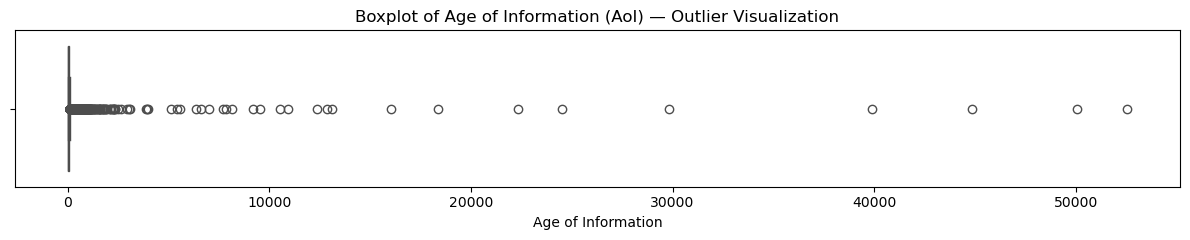

In [12]:
# Boxplot to visualize outliers in the 'age_of_information' column

plt.figure(figsize=(12, 2.5))
sns.boxplot(x=df_filtered['age_of_information'], color="orange")
plt.title("Boxplot of Age of Information (AoI) — Outlier Visualization")
plt.xlabel("Age of Information")
plt.tight_layout();

In [13]:
# Count how many inf values appear for each traffic type
inf_traffic_counts = df[df['age_of_information'].isin([np.inf, -np.inf])]['traffic_type'].value_counts()
inf_traffic_counts

traffic_type
deadline-oriented    720
AoI-oriented         677
Name: count, dtype: int64

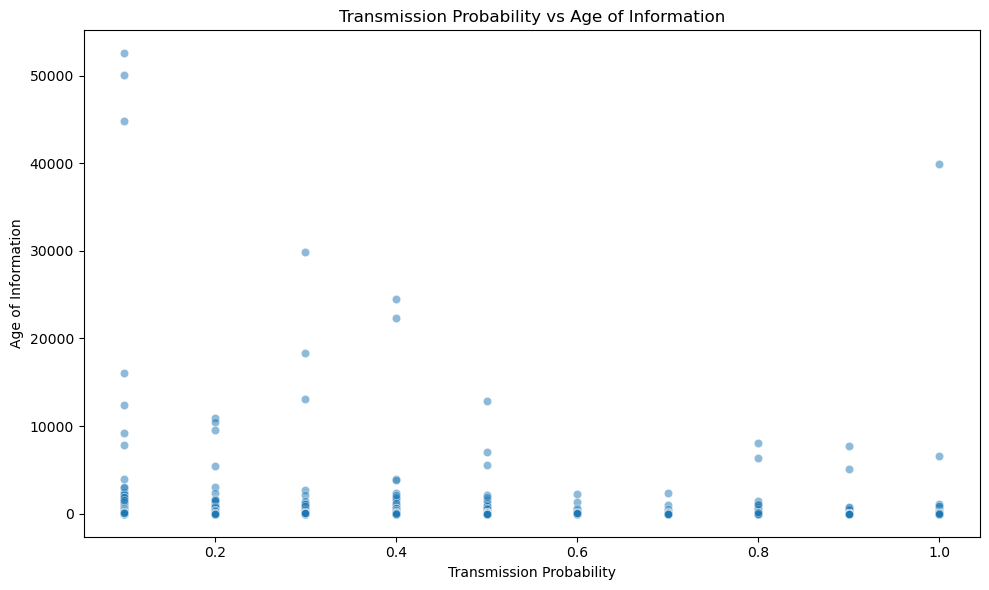

In [14]:
# Scatter plot: transmission_probability vs age_of_information
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_filtered, x="transmission_probability", y="age_of_information", alpha=0.5)
plt.title("Transmission Probability vs Age of Information")
plt.xlabel("Transmission Probability")
plt.ylabel("Age of Information")
plt.tight_layout();

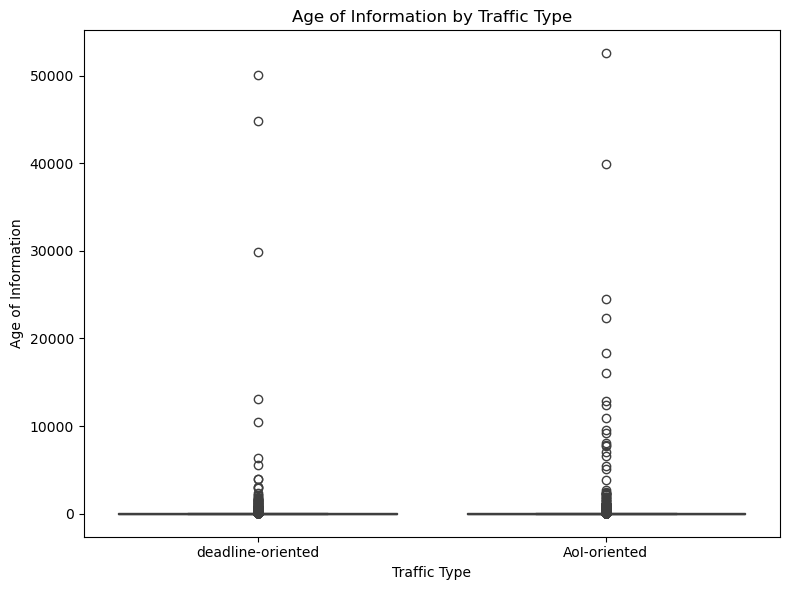

In [15]:
# Box plot: age_of_information by traffic_type
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_filtered, x="traffic_type", y="age_of_information")
plt.title("Age of Information by Traffic Type")
plt.xlabel("Traffic Type")
plt.ylabel("Age of Information")
plt.tight_layout();

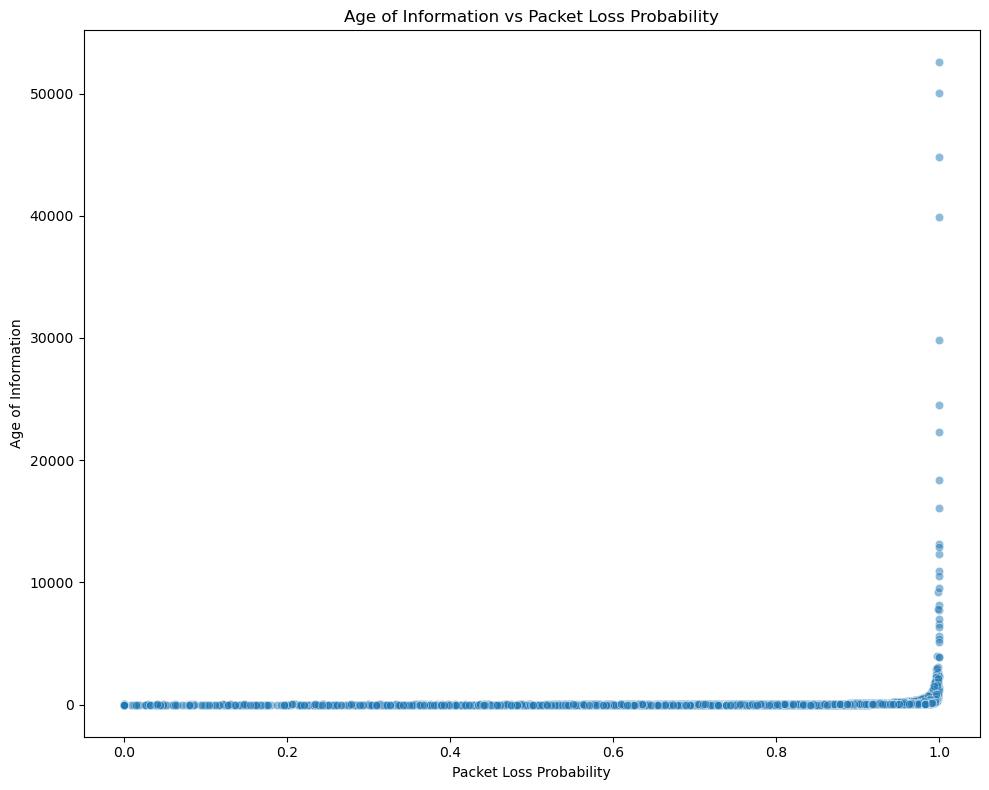

In [16]:
# Scatter plot: AoI vs. Packet Loss Probability
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_filtered, x="packet_loss_probability", y="age_of_information", alpha=0.5)
plt.title("Age of Information vs Packet Loss Probability")
plt.xlabel("Packet Loss Probability")
plt.ylabel("Age of Information")
plt.tight_layout();

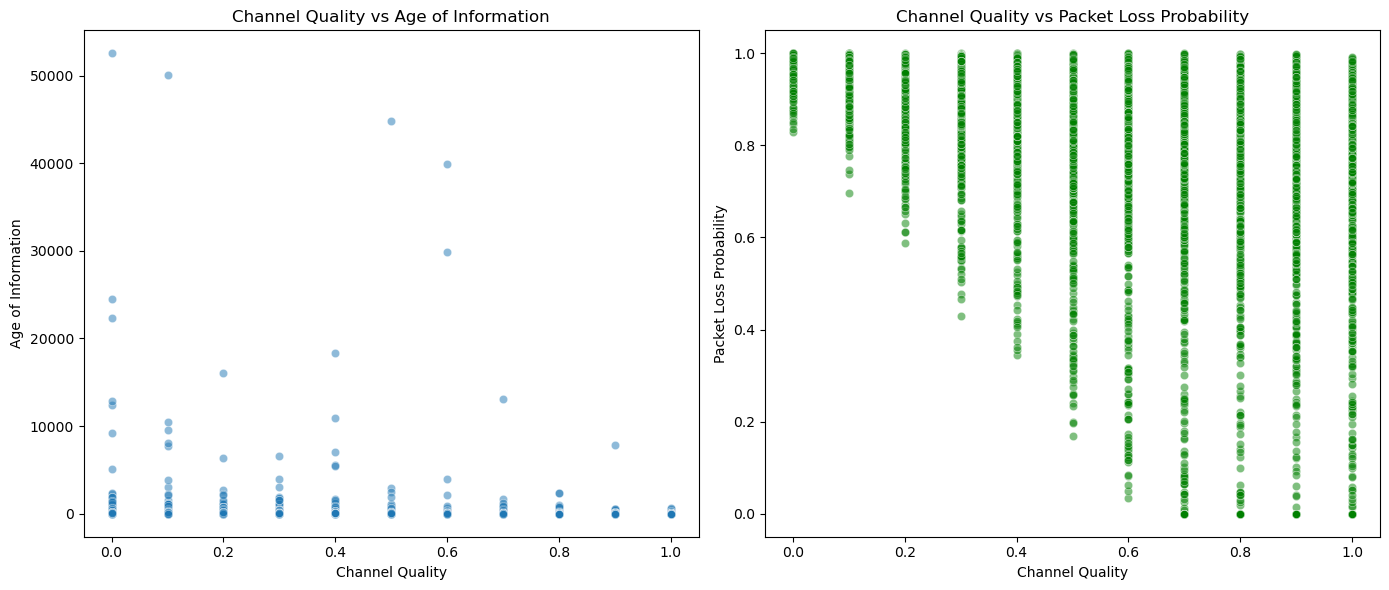

In [17]:
# Channel Quality vs AoI and PLP (2 subplots)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Channel Quality vs AoI
sns.scatterplot(data=df_filtered, x="channel_quality", y="age_of_information", alpha=0.5, ax=axes[0])
axes[0].set_title("Channel Quality vs Age of Information")
axes[0].set_xlabel("Channel Quality")
axes[0].set_ylabel("Age of Information")

# Channel Quality vs Packet Loss Probability
sns.scatterplot(data=df_filtered, x="channel_quality", y="packet_loss_probability", alpha=0.5, ax=axes[1], color='green')
axes[1].set_title("Channel Quality vs Packet Loss Probability")
axes[1].set_xlabel("Channel Quality")
axes[1].set_ylabel("Packet Loss Probability")

plt.tight_layout();

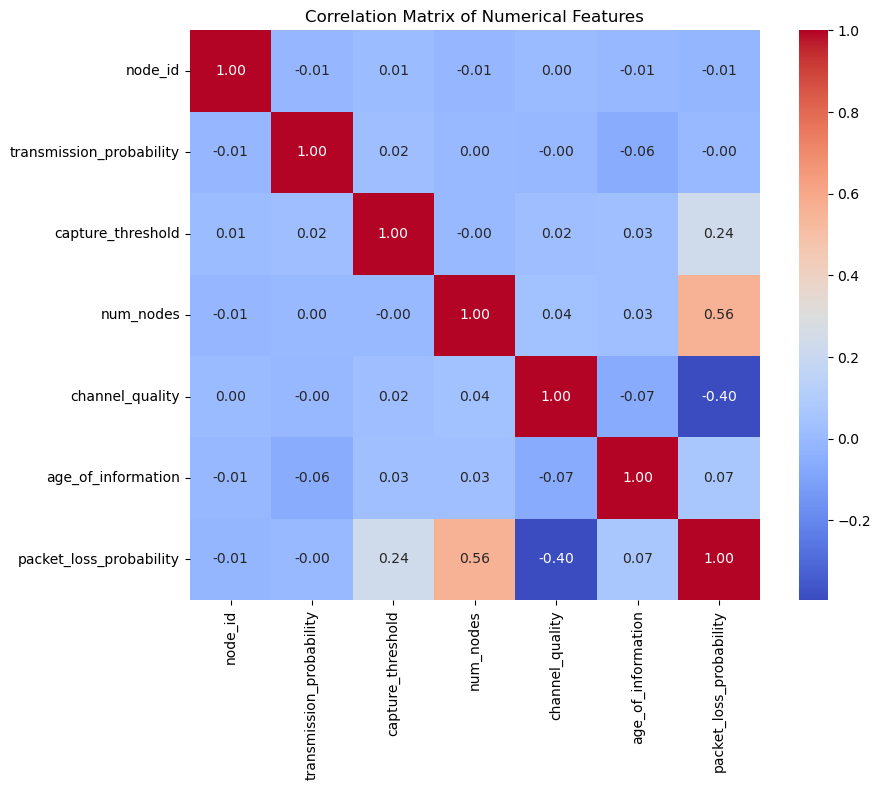

In [18]:
# Heatmap: correlation between numerical variables
plt.figure(figsize=(10, 8))
corr = df_filtered.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Matrix of Numerical Features")
plt.tight_layout();

### Observations on Visualizations:

**1. Boxplot – AoI Outlier Visualization:**

The boxplot reveals significant outliers in age_of_information, with several extreme values far above the upper whisker.

These high AoI points indicate data staleness likely caused by network congestion, failed transmissions, or poor link quality.

**2. Value Count – Inf AoI by Traffic Type:**

Both traffic types produced infinite AoI.

Infinite AoI means updates were missed, possibly due to low transmission probability or high packet loss.

**3. Scatter Plot – Transmission Probability vs AoI:**

Clear negative correlation: as transmission_probability increases, age_of_information generally decreases.

Higher transmission frequency improves data freshness, especially for AoI-sensitive applications.

**4. Boxplot – AoI by Traffic Type:**

AoI-oriented traffic maintains a lower median AoI with fewer extreme values.

Deadline-oriented traffic shows a broader distribution, indicating more variability and tolerance for older data.

Highlights the effect of traffic prioritization policies on network performance.

**5. Scatter Plot – AoI vs Packet Loss Probability:**

A positive relationship: higher packet_loss_probability results in higher AoI.

It suggests that data loss directly impacts freshness—mitigating packet loss is essential to keep AoI low.

**6. Dual Scatter Plots – Channel Quality vs AoI and PLP:**

Channel Quality vs AoI: Low-quality channels are associated with higher AoI.

Channel Quality vs PLP: Strong inverse correlation—better channel quality - fewer packet losses.

It reinforces that signal integrity is a key driver of performance.

**7. Heatmap – Correlation Between Numerical Features:**

AoI is negatively correlated with transmission_probability.

PLP is negatively correlated with channel_quality.

It confirms and quantifies the relationships seen in scatter plots.




**Trends:**

**1. High Transmission Probability Reduces AoI**

Evidence: Scatter plot of transmission_probability vs age_of_information

Insight:

There is a negative correlation: as transmission probability increases, AoI decreases.

This suggests that frequent transmissions help maintain fresher information in the network.

In systems where AoI is critical (like real-time monitoring), high transmission frequency is essential.

**2. Poor Channel Quality Leads to Higher PLP and AoI**

Evidence: Dual scatter plots of channel_quality vs age_of_information and channel_quality vs packet_loss_probability

Insight:

Lower channel_quality is associated with higher packet loss and larger AoI.

This shows that bad network conditions (e.g., noise, interference) degrade both data reliability and timeliness.

Enhancing physical layer properties (like SNR or bandwidth) can reduce PLP and AoI.

**3. Traffic Type Significantly Affects AoI**

Evidence: Box plot and histogram comparing AoI across traffic_type

Insight:

AoI-oriented traffic has lower and tighter AoI distributions, which means data freshness is maintained.

Deadline-oriented traffic is more tolerant to delay, leading to higher AoI variability and outliers.

Tailoring scheduling or routing strategies based on traffic type can optimize network performance.

**4. Presence of Extreme AoI Outliers**

Evidence: Boxplot of AoI values

Insight:

The dataset includes significant outliers or infinite values in AoI.

This implies network failure or extreme congestion in some configurations, which are important for stress testing and robustness checks.



# 3. Machine Learning Model Development (35 points)

Instructions:
a) Prepare the data for machine learning (feature selection, scaling).
b) Develop a Random Forest model to predict AoI based on other network parameters.
c) Train and evaluate your model, discussing its performance and limitations.
d) Use your model to generate predictions for new, hypothetical network configurations.

Complete the code below and add your analysis.

In [21]:
# Clean the age_of_information column by removing infinity values, making it safe to use for modeling and analysis
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["age_of_information"])

# Prepare the data
X = df[['transmission_probability', 'capture_threshold', 'num_nodes', 'channel_quality', 'packet_loss_probability']]
y_aoi = df['age_of_information']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_aoi, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)



RandomForestRegressor(random_state=42)

Mean Squared Error (MSE): 427448.7869397295
R-squared Score (R²): 0.8058665775398959


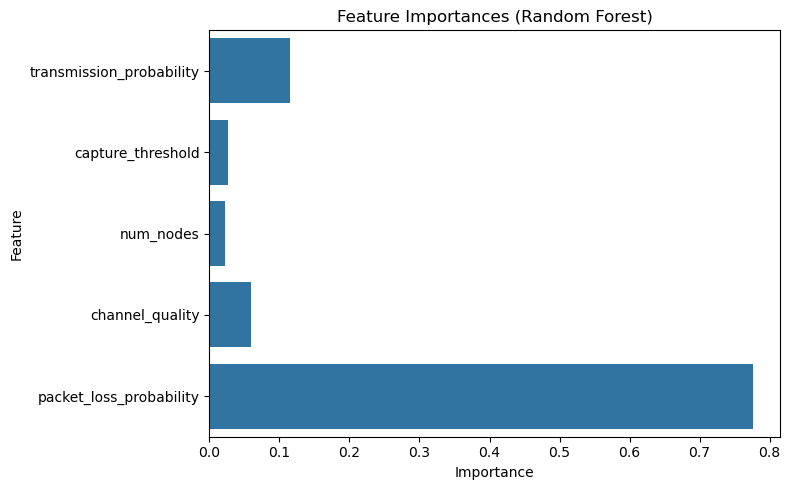

In [22]:
# Make predictions
y_pred = rf_model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared Score (R²):", r2)


# Feature importance
importances = rf_model.feature_importances_
feature_names = X.columns

# Plot feature importances
plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout();


## Write your analysis of the model performance and feature importances here:

**Model Evaluation Metrics**

Mean Squared Error (MSE) of ~427,449: This is the average squared difference between predicted and actual Age of Information (AoI).
A lower MSE indicates better model performance. 427,499 is large, but it is relative to the scale of AoI values in the dataset, which includes some very large outliers.

R-squared Score (R²) of ~0.806: This means that approximately 80.6% of the variance in AoI is explained by the model.
It is a strong indicator that the Random Forest model is capturing important patterns in the data and generalizes well to new/unseen samples.

**Feature Importance Analysis**

- packet_loss_probability	- Highest-	It has the greatest impact on AoI. More packet loss leads to older information.
- transmission_probability - High-	Higher transmission chances reduce AoI—more frequent updates keep data fresh.
- channel_quality	- Moderate-	Poor channel quality leads to data delays, increasing AoI.
- capture_threshold- Lower-	Some effect, likely influences transmission success indirectly.
- num_nodes- Lower-	Minimal impact—possibly due to shared scheduling or redundancy.


In [24]:
# Generate predictions for new, hypothetical network configurations:


# Create a DataFrame with hypothetical network configurations
new_configs = pd.DataFrame({
    'transmission_probability': [0.5, 0.7, 0.9],
    'capture_threshold': [0, 1, -1],
    'num_nodes': [3, 5, 7],
    'channel_quality': [0.6, 0.8, 0.4],
    'packet_loss_probability': [0.2, 0.1,0.3]
    
})

# Scale the new configurations using the same scaler as the training data
new_configs_scaled = scaler.transform(new_configs)

# Generate predictions using the trained Random Forest model
predicted_aoi = rf_model.predict(new_configs_scaled)

# Combine predictions with the input configurations
new_configs['predicted_age_of_information'] = predicted_aoi

# Display the results
print(new_configs)

   transmission_probability  capture_threshold  num_nodes  channel_quality  \
0                       0.5                  0          3              0.6   
1                       0.7                  1          5              0.8   
2                       0.9                 -1          7              0.4   

   packet_loss_probability  predicted_age_of_information  
0                      0.2                      2.737986  
1                      0.1                      2.116903  
2                      0.3                      2.149754  


### Observation on predictions for new hypothetical network configuration

These predictions align well with how AoI behaves in real networks:

High PLP and low channel quality hurt performance, even with frequent transmissions.

Balanced network settings with high reliability yield the best AoI.

The model appears to capture key relationships effectively for these hypothetical cases.

# 4. Analysis and Insights (20 points)
### Instructions:
Based on your data exploration and machine learning results:

**a) Discuss the key factors that appear to influence the AoI-PLP trade-off in IIoT networks.**

From both exploratory analysis and machine learning results, the following factors significantly influence the trade-off between Age of Information (AoI) and Packet Loss Probability (PLP):

- Transmission Probability: Higher values reduce AoI by enabling more frequent updates. However, too many transmissions can lead to collisions, increasing PLP in dense networks.

- Packet Loss Probability (PLP): Strongest predictor of AoI. High PLP directly causes data staleness. It is often influenced by channel conditions and node interference.

Channel Quality: Better channel quality decreases PLP and indirectly reduces AoI. Poor-quality channels lead to frequent retransmissions and delays.

Capture Threshold and Number of Nodes: High capture threshold (harder to decode signals) and more nodes (more contention) can degrade performance. These parameters control the network’s ability to resolve signal conflicts and manage scalability.


**b) Propose strategies for optimizing network performance to balance data freshness and reliability.**

To maintain low AoI while ensuring low PLP in Industrial IoT environments, consider the following strategies:

- Adaptive Transmission Control: Dynamically adjust transmission probabilities based on current PLP or channel feedback. Lower rates in congested periods; increase during clear channel conditions.

- Channel Quality-Aware Scheduling: Prioritize nodes with good channel conditions for transmission. Implement link-quality metrics in MAC layer protocols.

- Traffic Type Differentiation: Allocate resources based on traffic priority (e.g., give more bandwidth to AoI-sensitive data). Use traffic shaping to avoid congestion for critical updates.

- Topology-Aware Configuration: Limit node density per channel or cluster to reduce contention. Use hierarchical routing or gateways to offload data aggregation.

**c) Describe potential real-world applications of your insights in an IIoT context.**

- Smart Manufacturing (Industry 4.0): Real-time sensor data from robots and machinery needs fresh, reliable updates. Optimizing AoI helps in predictive maintenance and immediate anomaly detection.

- Power Grid Monitoring: Monitoring voltage, frequency, or transformer status in substations requires both low AoI and high reliability to prevent blackouts or overloads.

- Autonomous Logistics: AGVs (Automated Guided Vehicles) and drones in a warehouse depend on fresh location and tasking data. Balancing AoI and PLP ensures safe and efficient routing.

- Environmental Monitoring: Applications like pollution tracking or disaster response (flood sensors, fire alarms) need low AoI during critical events while maintaining system-wide reliability.


# 5. Bonus Challenge (10 points)

"""
Instructions:
Implement a simple deep learning model (e.g., a basic neural network) to predict both AoI and PLP simultaneously. 
Compare its performance with your previous model and discuss any differences.

Complete the code below and add your analysis.

In [28]:
# Prepare data for deep learning model
X = df[['transmission_probability', 'capture_threshold', 'num_nodes', 'channel_quality']]
y_aoi = df['age_of_information']
y_plp = df['packet_loss_probability']
X_train, X_test, y_aoi_train, y_aoi_test, y_plp_train, y_plp_test = train_test_split(
    X, y_aoi, y_plp, test_size=0.2, random_state=42)

In [29]:
# Create a simple neural network
model = Sequential([
    Input(shape=(4,)),                  
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2)  # Output layer for AoI and PLP
])

model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Evaluate the model
y_pred = model.predict(X_test)

# Slice predictions: AoI is column 0, PLP is column 1
y_pred_aoi = y_pred[:, 0]
y_pred_plp = y_pred[:, 1]

# Add your code here to make predictions and calculate MSE for both AoI and PLP
mse_aoi = mean_squared_error(y_aoi_test, y_pred_aoi)
mse_plp = mean_squared_error(y_plp_test, y_pred_plp)

print("MSE (Age of Information):", mse_aoi)
print("MSE (Packet Loss Probability):", mse_plp)

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MSE (Age of Information): 2173046.985876429
MSE (Packet Loss Probability): 22532.428888225117


## Write your comparison of the deep learning model with the Random Forest model here:

- The Random Forest model performs better on AoI prediction, achieving a lower MSE and strong R², indicating it explains ~80% of the variance in AoI because PLP was included in the input data.

- The Deep Learning model predicts both AoI and PLP, which adds value through multi-output prediction, but has a higher AoI error in this case. AoI was predicted without PLP.

- In Random Forest, packet loss probability dominates AoI prediction.

- Deep Learning doesn't offer feature importance but it handles complex nonlinear relationships between multiple features.

- The Random Forest model offers excellent interpretability through built-in feature importance metrics, making it easy to understand which variables influence predictions the most. It is a single-output model, meaning it can predict either AoI or PLP at a time, but not both simultaneously. Random Forest is also known for its fast training time and consistent performance, even on smaller datasets or with limited tuning. This makes it a great choice for quick, accurate, and explainable predictions.

- On the other hand, the Deep Learning model (neural network) supports multi-output prediction, allowing it to predict both Age of Information (AoI) and Packet Loss Probability (PLP) in one pass. However, it functions more like a black box, meaning it does not provide direct insight into which features are most influential. Deep learning models typically require more data and careful tuning of parameters (e.g., layers, learning rate, epochs) to perform well. While training may take longer, neural networks excel at capturing complex, nonlinear relationships in data that simpler models may miss.

- Random Forest is ideal for fast and interpretable predictions, while Deep Learning is more suitable for flexible, multi-target learning when interpretability is less of a priority and data volume is sufficient.

### References

Farag, H., Ali, S. M., & Stefanović, Č. (2023). On the analysis of AoI-reliability tradeoff in heterogeneous IIoT networks. arXiv preprint arXiv:2311.13336. https://arxiv.org/abs/2311.13336